# Cyclic Coordinate Descent for Logistic Regression with Lasso regularization

This notebook presents the implementation of Cyclic Coordinate Descent (CCD) algorithm for parameter 
estimation in regularized logistic regression with l1 (lasso) penalty and compares it with standard 
logistic regression model without regularization. 

TODO: 

    2. Comparison on real dataset

    3. Report

    7. Any other TODOS found in the notebook

    3. OPTIONAL: We could examine the case when n is low and d is high, and then check the effect of g

    1.  KINDOFDONE: Likelihood function values and coefficient values depending on *iteration*

    4. KINDOFDONE: OPTIONAL: Compare with some ready implementation of ccg, compare the lambda values, coefficients paths - compare our solution to glmnet

    5. DONE: OPTIONAL: Generate a dataset with some redundant varaibles and check whether they get set to 0

    6. OPTIONAL^2: Set beta start, as a result of log reg without l1, then less itration wiht small lambdas



# Imports & Consts

In [5]:
import os
from scipy.io import arff
import numpy as np
import pandas as pd
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    balanced_accuracy_score,
)
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
import gc
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning


sns.set_theme(style="whitegrid")
sns.set_palette("bright")
sns.set_context("notebook", font_scale=1.2)

In [6]:
CONST_DATASET_DIRECTORY_PATH = "./datasets"
CONST_RESULTS_DIRECTORY_PATH = "./results"

In [7]:
CONST_RESULTS_FILE_NAME = "results.pkl"
CONST_P_N_RESULTS_FILE_NAME = "p_n_results.pkl"
CONST_REDUNDANT_COMPARISON_RESULTS_FILE_NAME = "redundant_comparison_results.pkl"
CONST_COMPARISON_AT_LAMBDA_0_RESULTS_FILE_NAME = "comparison_at_lambda_0.pkl"

In [8]:
# Ensure reproducibility (More details in the README.md)
CONST_RANDOM_SEED = 42
np.random.seed(CONST_RANDOM_SEED)

# Classes & Functions

## Data preprocessing & Datasets

TODO: Find 4 datasets

In [9]:
def load_datasets(
    directory: str = CONST_DATASET_DIRECTORY_PATH,
) -> List[dict[str, pd.DataFrame]]:
    """Load all ARFF datasets from the datasets folder and return them as a list of dictionaries containing names and dataframes.

    Parameters
    ----------
    directory : str
        Path to the directory containing ARFF files.

    Returns
    -------
    List[dict[str, pd.DataFrame]]
        List of dictionaries where each dictionary contains:
        - 'name': str, name of the dataset
        - 'data': pd.DataFrame, the loaded dataset
    """
    datasets = []
    for file in os.listdir(directory):
        if file.endswith(".arff"):
            data = arff.loadarff(f"{directory}/{file}")
            df = pd.DataFrame(data[0])
            datasets.append({"name": file.strip(".arff"), "data": df})
    return datasets


def load_dataset(path: str) -> pd.DataFrame:
    """Load a dataset from a given path and return it as a pandas dataframe.

    Parameters
    ----------
    path : str
        Path to the ARFF dataset file.

    Returns
    -------
    pd.DataFrame
        The loaded dataset as a pandas DataFrame.
    """
    data = arff.loadarff(path)
    return pd.DataFrame(data[0])

In [10]:
class Dataset:
    """Represents the dataset with the name, features, target, and preprocessing steps.
    Features and target are available as numpy arrays after preprocessing.
    """

    def __init__(
        self, name: str, df: pd.DataFrame, preprocessing_steps: List[callable] = None
    ):
        """Initialize a new dataset with a name, data, and preprocess the data resulting in two numpy arrays. X - features, and y - target.

        Parameters
        ----------
        name : str
            Name of the dataset
        df : pd.DataFrame
            Input dataframe containing features and target. The last column is considered the target.
        preprocessing_steps : List[callable], optional
            List of preprocessing functions to apply to features
        """
        self.name = name
        self.preprocessing_steps = preprocessing_steps

        self.X = df[df.columns[:-1]]
        self.y = df[df.columns[-1]]

        for step in self.preprocessing_steps:
            self.X = step(self.X)

        # Rest of the implementation remains the same
        self.X = self.X.to_numpy()
        self.class_names = self.y.unique()
        self.y = self.y.copy()
        indexes_0 = np.where(self.y == self.class_names[0])
        indexes_1 = np.where(self.y == self.class_names[1])
        self.y[indexes_0] = 0
        self.y[indexes_1] = 1
        self.y = self.y.to_numpy()

    def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
        """Fill the missing values in the dataframe using the mean of the column strategy.

        Parameters
        ----------
        df : pd.DataFrame
            Input dataframe with missing values

        Returns
        -------
        pd.DataFrame
            Dataframe with missing values filled with column means
        """
        return df.fillna(df.mean())

    def remove_colinear_features(
        df: pd.DataFrame, threshold: float = 0.8
    ) -> pd.DataFrame:
        """Remove features of a dataframe that are colinear.

        Parameters
        ----------
        df : pd.DataFrame
            Input dataframe
        threshold : float, optional
            Correlation threshold for feature removal (default=0.8)

        Returns
        -------
        pd.DataFrame
            Dataframe with colinear features removed
        """
        corr_matrix = df.corr().abs()
        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        to_drop = [
            column for column in upper_tri.columns if any(upper_tri[column] > threshold)
        ]
        return df.drop(columns=to_drop)

    def normalize(df: pd.DataFrame) -> pd.DataFrame:
        """Normalize the features of a dataframe based on Min-Max.

        Parameters
        ----------
        df : pd.DataFrame
            Input dataframe to normalize

        Returns
        -------
        pd.DataFrame
            Normalized dataframe with values in range [0, 1]
        """
        return (df - df.min()) / (df.max() - df.min())


class APBreastKidney(Dataset):
    """APBreastKidney dataset.
    source: https://www.openml.org/search?type=data&sort=runs&id=1158&status=active
    """

    dataset_path = f"{CONST_DATASET_DIRECTORY_PATH}/AP_Breast_Kidney.arff"

    def __init__(self):
        """Initialize the APBreastKidney dataset"""
        data = load_dataset(APBreastKidney.dataset_path)
        super().__init__(
            "APBreastKidney",
            data,
            [
                Dataset.fill_missing_values,
                Dataset.remove_colinear_features,
                Dataset.normalize,
            ],
        )


class SyntheticDataset(Dataset):
    def __init__(self, p=0.5, n=1000, d=10, g=0.1):
        """Initialize the synthetic dataset with the given parameters.

        Parameters
        ----------
        p : float, optional
            Class prior probability (default=0.5)
        n : int, optional
            Number of samples (default=1000)
        d : int, optional
            Number of features/dimensions (default=10)
        g : float, optional
            Covariance matrix parameter (default=0.1)
        """
        y = np.random.binomial(1, p, n)
        X = np.zeros((n, d))

        X[y == 0] = np.random.multivariate_normal(
            np.zeros(d),
            np.array([[np.pow(g, np.abs(i - j)) for i in range(d)] for j in range(d)]),
            sum(y == 0),
        )
        X[y == 1] = np.random.multivariate_normal(
            np.array([1 / (i + 1) for i in range(d)]),
            np.array([[np.pow(g, np.abs(i - j)) for i in range(d)] for j in range(d)]),
            sum(y == 1),
        )

        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        data = pd.DataFrame(data)

        super().__init__(
            "SyntheticDataset",
            data,
            [
                Dataset.normalize,
            ],
        )


class RedundantFeaturesDataset(Dataset):

    def __init__(
        self,
        n_samples: int = 1000,
        n_features: int = 20,
        n_informative: int = 5,
        random_state: int = CONST_RANDOM_SEED,
    ) -> None:
        """
        Generates a dataset with redundant features.
        Some features will have zero impact on the target variable.

        Parameters:
        - n_samples: int, number of samples
        - n_features: int, total number of features
        - n_informative: int, number of informative features (rest will be redundant/noise)
        - random_state: int, random seed for reproducibility

        Returns:
        - X: Feature matrix (numpy array)
        - y: Target variable (numpy array)
        """
        np.random.seed(random_state)

        beta_true = np.concatenate(
            [np.ones(n_informative), np.zeros(n_features - n_informative)]
        )

        X = np.random.randn(n_samples, n_features)

        linear_combination = X.dot(beta_true)

        pi = 1 / (1 + np.exp(-linear_combination))

        y = np.random.binomial(1, pi)

        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        data = pd.DataFrame(data)

        super().__init__(
            "RedundantFeaturesDataset",
            data,
            [
                Dataset.normalize,
            ],
        )

## LogRegCCD

Implementation of regularized Logistic Regression with Cyclic Coordinate Descent based on the [publication](https://www.jstatsoft.org/article/view/v033i01) (Chapter 3 is most relevant).

In [11]:
def precision(y_true, y_pred):
    """Calculate precision score while handling zero division.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        Precision score in range [0, 1].
    """
    return precision_score(y_true, y_pred, zero_division=0.0)


def recall(y_true, y_pred):
    """Calculate recall score while handling zero division.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        Recall score in range [0, 1].
    """
    return recall_score(y_true, y_pred, zero_division=0.0)


def f1(y_true, y_pred):
    """Calculate F1 score while handling zero division.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        F1 score in range [0, 1].
    """
    return f1_score(y_true, y_pred, zero_division=0.0)


def balanced_accuracy(y_true, y_pred):
    """Calculate balanced accuracy score.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        Balanced accuracy score in range [0, 1].
    """
    return balanced_accuracy_score(y_true, y_pred)


def roc_auc(y_true, y_pred):
    """Calculate ROC AUC score.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Target scores, can either be probability estimates, confidence values, or decisions.

    Returns
    -------
    float
        ROC AUC score in range [0, 1].
    """
    return roc_auc_score(y_true, y_pred)


def accuracy(y_true, y_pred):
    """Calculate accuracy score.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        Accuracy score in range [0, 1].
    """
    return accuracy_score(y_true, y_pred)

### LogRegCCD Algorithm

Logistic Regression is a machine learning method capable of binary classification. It predicts the probability of an outcome. Its steps are as follows:

Compute a linear combination of input features:

$$
z = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n = \mathbf{w}^T \mathbf{x} + b
$$

Where:
- $x$ denotes input feature vector, where $x_1,...,x_n$ are the elements of that vector
- $w$ denotes model weights vector 
- $b$ is the bias term  

The output $z$ is then provided to the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

The output in range [0,1] denotes the probability that given feature vector $x$ belongs to the positive class.

Prediction rule is based on the output of the sigmoid function, if it's larger than 0.5 we assign to class 1, otherwise assign to class 0.

To fit the model to the training data. One needs to minimize the loss function, in this case Binary Cross-Entropy:

$$
\mathcal{L} = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log \hat{y}^{(i)} + \left(1 - y^{(i)}\right) \log \left(1 - \hat{y}^{(i)}\right) \right]
$$

Where:
- $m$ denotes the number of training examples  
- $y^{(i)}$ is the class label 
- $\hat{y}^{(i)}$ is the predicted probability  


The weights of the model need to be optimized to find the proper fit, this can be achieved by standard gradient descent:

$$
w_j := w_j - \alpha \frac{\partial \mathcal{L}}{\partial w_j}
$$

$$
b := b - \alpha \frac{\partial \mathcal{L}}{\partial b}
$$

Where:
- $\alpha$ is the learning rate, the higher the value the more aggressive weight updates  
- $\frac{\partial \mathcal{L}}{\partial w_j}$ is a gradient with respect to weight $w_j$


Lasso Regulaization is used to prevent overfitting, when the trained model can predict samples from the training set very well but struggles on the test set.

Then the loss function becomes:

$$
\mathcal{L}_{\text{lasso}} = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log \hat{y}^{(i)} + \left(1 - y^{(i)}\right) \log \left(1 - \hat{y}^{(i)}\right) \right] + \lambda \sum_{j=1}^{n} |w_j|
$$

Where:
- $m$  is the number of training samples  
- $y^{(i)}$ is the class label
- $\hat{y}^{(i)}$ is the predicted probability 
- $\lambda$ denotes regularization strength 

In essence during the training process, the model will also minizem the absolute sum of the coefficients in addition to the loss function

Now, to use the Cyclic Coordinate Descent instead of the standard Gradient Descent one needs to minimize the $\mathcal{L}_{\text{lasso}}$ using a different algorithm for updating model weights.

However the authors of the [publication](https://www.jstatsoft.org/article/view/v033i01) present a more sophisticated approach with certain optimizations so let us focus on them first.

First, the Logistic Regression log-likelihood is approximated with a quadratic approximation:

$$
\ell_Q(\beta_0, \beta) = -\frac{1}{2N} \sum_{i=1}^{N} w_i (z_i - \beta_0 - x_i^T \beta)^2 + C
$$

That converts the problem into a penalized weighted least squares.

The authors also use a regularization path that starts from largest $\lambda$ where $\beta = 0$ and decreases $\lambda$ gradually, using previous solutions as warm starts.

Instead of computing gradients from scratch with each iteration, the authors propose to use covariance updates:

$$
\sum_{i=1}^{N} x_{ij} r_i = \langle x_j, y \rangle - \sum_{k: \beta_k \neq 0} \langle x_j, x_k \rangle \beta_k
$$

For each feature $j$, the optimization problem simplifies to:

$$
\min_{\beta_j} \left[ \frac{1}{2} \sum_{i=1}^{N} w_i \left( z_i - \beta_0 - \sum_{k \neq j} x_{ik} \beta_k - x_{ij} \beta_j \right)^2 + \lambda |\beta_j| \right]
$$

To update the weights using CCD one needs to (for weight j):
1. Compute partial residuals (excluding $\beta_j$):

   $$
   r_i = z_i - (\beta_0 + \sum_{k \neq j} x_{ik} \beta_k)
   $$

2. Compute the gradient component $\rho_j$:

   $$
   \rho_j = \sum_{i=1}^{N} w_i x_{ij} r_i
   $$

3. Apply soft-thresholding for L1 regularization:

   $$
   \beta_j = \frac{S(\rho_j, \lambda)}{\sum_{i=1}^{N} w_i x_{ij}^2}
   $$

   where the soft-thresholding operator is:

   $$
   S(z, \lambda) = \text{sign}(z) \cdot \max(|z| - \lambda, 0)
   $$

And then $\beta_0$ that is not regularized:
$$
\beta_0 = \frac{\sum_{i=1}^{N} w_i (z_i - x_i^T \beta)}{\sum_{i=1}^{N} w_i}
$$


From a high level overview the presented algorithm consists of:

1. Outer Loop:
   - Decrease $\lambda$ along a regularization path.

2. Middle Loop:
   - Update the quadratic approximation using the current $(\beta_0, \beta)$.

3. Inner Loop:
   - Perform coordinate descent on the penalized weighted least squares problem.



In [12]:
class LogRegCCD:
    """Logistic Regression with Coordinate Cyclic Descent and Lasso Regularization."""

    def __init__(self) -> None:
        """Initialize the LogRegCCD model."""
        self.lambda_ = None

        self.beta = None
        self.beta_0 = None
        self.weights = []

        # We have noticed that after a certain point, model's accuracy starts to decrease
        # Therefore, we add the possibility to perform early stopping based on the validation set

        self.best_lambda = None
        self.best_beta = None
        self.best_beta_0 = None

        # Keep track of weights for each iteration for each lambda for later analysis

        self.metrics = {}

    def fit(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_valid: np.ndarray = None,
        y_valid: np.ndarray = None,
        measure: callable = None,
        regularization_path_lambda_sequence: np.ndarray = np.logspace(
            1, -3, 50
        ),  # The model is quite sensitive to the lambda values, high lambda values may result in all coefficients being zero
        maximum_iterations: int = 1000,
        convergance_threshold: float = 1e-05,
        minimum: float = 1e-05,
        track_likelihood_and_weights: bool = False,
    ) -> None:
        """Fit the Logsitic Regression model on provided training features and labels.

        Parameters
        ----------
        X_train : np.ndarray
            Training features
        y_train : np.ndarray
            Training labels
        X_valid : np.ndarray, optional
            Validation features, by default None
        y_valid : np.ndarray, optional
            Validation labels, by default None
        measure : callable, optional
            Evaluation measure to use for validation, by default None
        regularization_path_lambda_sequence : np.ndarray, optional
            Regularization path lambda sequence, by default np.logspace(1, -3, 50)
        maximum_iterations : int, optional
            Maximum number of iterations, by default 1000
        convergance_threshold : float, optional
            Convergence threshold, by default 1e-05
        minimum : float, optional
            Minimum value to handle 0 divisions, by default 1e-05
        track_likelihood_and_weights : bool, optional
            Track likelihood and weights for each iteration, by default False

        Returns
        -------
        None
            Fits the model and stores the weights and metrics

        """

        _, number_of_features = X_train.shape
        self.beta = np.zeros(number_of_features)  # Initialize coefficients
        self.beta_0 = 0  # Initialize intercept

        # Track the likelihood and weights for each iteration
        self.metrics = {
            lambda_: {
                "likelihood": [],
                "beta": [],
                "intercept": [],
                "iteration": [],
                "metric": 0,
            }
            for lambda_ in regularization_path_lambda_sequence
        }

        for (
            lambda_
        ) in (
            regularization_path_lambda_sequence
        ):  # Outer Loop: Decrease $ \lambda $ along a regularization path.

            self.lambda_ = lambda_

            if track_likelihood_and_weights == True:
                self.metrics[lambda_]["likelihood"].append(
                    self._get_log_likelihood(X_train, y_train)
                )
                self.metrics[lambda_]["beta"].append(self.beta.copy())
                self.metrics[lambda_]["intercept"].append(self.beta_0)
                self.metrics[lambda_]["iteration"].append(0)

            for iteration_index in range(
                maximum_iterations
            ):  # Middle Loop: Update the quadratic approximation using the current $ (\beta_0, \beta) $.

                previous_beta = self.beta.copy()
                previous_beta_0 = self.beta_0

                # Linear Predictions and Probabilities

                linear_prediction = self.beta_0 + np.dot(X_train, self.beta)
                probabilities = self.sigmoid(linear_prediction)

                # Weights and Working Response

                weights = np.maximum(minimum, probabilities * (1 - probabilities))
                working_response = linear_prediction + np.divide(
                    y_train - probabilities, weights, where=weights != 0
                )

                # Update the intercept \beta_0

                self.beta_0 = np.divide(
                    np.sum(weights * (working_response - np.dot(X_train, self.beta))),
                    np.sum(weights),
                    where=np.sum(weights) != 0,
                )

                # Coordinate Descent for each feature

                for feature_index in range(
                    number_of_features
                ):  # Inner Loop: Update the coefficients $ \beta $

                    # Compute the partial residual

                    partial_residual = (
                        working_response
                        - self.beta_0
                        - np.dot(
                            X_train[:, np.arange(number_of_features) != feature_index],
                            self.beta[np.arange(number_of_features) != feature_index],
                        )
                    )

                    # Compute the coordinate-wise derivative

                    coordinate_derivative = np.dot(
                        weights * X_train[:, feature_index], partial_residual
                    )

                    # Soft-thresholding

                    denominator = np.sum(weights * X_train[:, feature_index] ** 2)
                    self.beta[feature_index] = np.divide(
                        self.soft_thresholding(coordinate_derivative, lambda_),
                        denominator,
                        where=denominator != 0,
                    )

                # Track the likelihood and weights for each iteration
                if track_likelihood_and_weights == True:
                    self.metrics[lambda_]["likelihood"].append(
                        self._get_log_likelihood(X_train, y_train)
                    )
                    self.metrics[lambda_]["beta"].append(self.beta.copy())
                    self.metrics[lambda_]["intercept"].append(self.beta_0)
                    self.metrics[lambda_]["iteration"].append(iteration_index + 1)

                # Check for convergence

                if (
                    np.linalg.norm(self.beta - previous_beta) < convergance_threshold
                    and np.abs(self.beta_0 - previous_beta_0) < convergance_threshold
                ):
                    break

            self.weights.append(
                {
                    "lambda": lambda_,
                    "weights": self.beta.copy(),
                    "intercept": self.beta_0,
                }
            )

            # Calculate the metric on the validation set
            if X_valid is not None and y_valid is not None and measure is not None:
                self.metrics[lambda_]["metric"] = self.validate(
                    X_valid, y_valid, measure, best_lambda=False
                )

        # Find the best lambda based on the validation set
        if X_valid is not None and y_valid is not None and measure is not None:
            self.best_lambda = max(
                self.metrics, key=lambda l: self.metrics[l]["metric"]
            )

            best_model = [
                model for model in self.weights if model["lambda"] == self.best_lambda
            ][0]

            self.best_beta, self.best_beta_0 = (
                best_model["weights"],
                best_model["intercept"],
            )

    def _get_log_likelihood(
        self, X: np.ndarray, y: np.ndarray, best_lambda: bool = False
    ) -> float:
        """Compute the log likelihood of the model.

        Parameters
        ----------
        X : np.ndarray
            Features
        y : np.ndarray
            Labels
        best_lambda : bool, optional
            Use the best lambda found by using the validation set, by default False

        Returns
        -------
        float
            Log likelihood of the model

        """

        if best_lambda is True:
            weights = self.best_beta
            intercept = self.best_beta_0
            lambda_ = self.best_lambda
        else:
            weights = self.beta
            intercept = self.beta_0
            lambda_ = self.lambda_
        # y = beta_0 + beta_1 * x_1 + beta_2 * x_2 + ... + beta_n * x_n
        linear_prediction = intercept + np.dot(X, weights)

        # According to the logsitic regression log likelihood formula, given in the explanation above
        return np.sum(
            y * linear_prediction - np.log(1 + np.exp(linear_prediction))
        ) - lambda_ * np.sum(np.abs(weights))

    def validate(
        self,
        X_valid: np.ndarray,
        y_valid: np.ndarray,
        measure: callable,
        best_lambda: bool = True,
    ) -> float:
        """Compute the provided measure based on the validation features and labels.

        Parameters
        ----------
        X_valid : np.ndarray
            Validation features
        y_valid : np.ndarray
            Validation labels
        measure : callable
            Evaluation measure to use
        best_lambda : bool, optional
            Use the best lambda found by using the validation set, by default True

        Returns
        -------
        float
            Evaluation measure value

        """
        if measure.__name__ == roc_auc.__name__:
            return measure(y_valid, self.predict_proba(X_valid, best_lambda))
        return measure(y_valid, self.predict(X_valid, best_lambda))

    def predict(
        self, X_test: np.ndarray, best_lambda: bool = True, threshold: float = 0.5
    ) -> np.ndarray:
        """Predict the classes for the test features.

        Parameters
        ----------
        X_test : np.ndarray
            Test features
        best_lambda : bool, optional
            Use the best lambda found by using the validation set, by default True
        threshold : float, optional
            Threshold for the probability, by default 0.5

        Returns
        -------
        np.ndarray
            Predicted classes

        """
        probability = self.predict_proba(X_test, best_lambda)
        if probability is None:
            return None
        return probability > threshold

    def predict_proba(self, X_test: np.ndarray, best_lambda: bool = True) -> np.ndarray:
        """Predict the probabilities of the classes for the test features.

        Parameters
        ----------
        X_test : np.ndarray
            Test features
        best_lambda : bool, optional
            Use the best lambda found by using the validation set, by default True

        Returns
        -------
        np.ndarray
            Predicted probabilities

        """
        if best_lambda is True and (
            self.best_beta is None
            or self.best_beta_0 is None
            or self.best_lambda is None
        ):
            print(
                "Please fit the model first with validation set if you wish to use best lambda parameter or set the best_lambda argument to False."
            )
            return None
        return (
            self.sigmoid(self.best_beta_0 + np.dot(X_test, self.best_beta))
            if best_lambda
            else self.sigmoid(self.beta_0 + np.dot(X_test, self.beta))
        )

    def plot(
        self, measure: callable, X_test: np.ndarray, y_test: np.ndarray, figsize=(6, 4)
    ) -> None:
        """Plot the evalueation measure over different values of lambda.

        Parameters
        ----------
        measure : callable
            Evaluation measure to plot
        X_test : np.ndarray
            Test features
        y_test : np.ndarray
            Test labels
        figsize : tuple, optional
            Figure size, by default (6, 4)

        Returns
        -------
        None
            Plot the evaluation measure over different values of lambda

        """

        coefficients_df = pd.DataFrame(self.weights)
        coefficients_df = coefficients_df.set_index("lambda")
        coefficients_df = coefficients_df.sort_index(ascending=False)

        measures = []
        for w in self.weights:
            self.beta = w["weights"]
            self.beta_0 = w["intercept"]
            measures.append(measure(y_test, self.predict(X_test, best_lambda=False)))

        plt.figure(figsize=figsize)
        plt.plot(coefficients_df.index, measures)
        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Measure Value")
        plt.title(f"Model Performance ({measure.__name__}) vs Lambda")
        plt.grid(True)
        plt.gca().invert_xaxis()
        fig = plt.gcf()
        plt.show()

    def plot_coefficients(self, figsize=(6, 4)) -> None:
        """Plot the coefficients of the model over different values of lambda.

        Parameters
        ----------
        figsize : tuple, optional
            Figure size, by default (6, 4)

        Returns
        -------
        None
            Plot the coefficients over different values of lambda

        """

        coefficients_df = pd.DataFrame(self.weights)
        coefficients_df = coefficients_df.set_index("lambda")
        coefficients_df = coefficients_df.sort_index(ascending=False)

        weights_df = pd.DataFrame(
            coefficients_df["weights"].tolist(),
            index=coefficients_df.index,
            columns=[f"beta_{i}" for i in range(len(self.beta))],
        )

        plt.figure(figsize=figsize)
        for col in weights_df.columns:
            plt.plot(weights_df.index, weights_df[col], label=col)

        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient Paths")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.grid(True)
        plt.gca().invert_xaxis()
        fig = plt.gcf()
        plt.show()

    def plot_validation_scores(self, figsize=(6, 4)) -> None:
        """Plot the validation scores over different values of lambda.

        Parameters
        ----------
        figsize : tuple, optional
            Figure size, by default (6, 4)

        Returns
        -------
        None
            Plot the validation scores over different values of lambda

        """
        plt.figure(figsize=figsize)
        xAxis = list(self.metrics.keys())
        yAxis = [self.metrics[lambda_]["metric"] for lambda_ in xAxis]
        plt.plot(xAxis, yAxis)
        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Validation Score")
        plt.title("Validation Score vs Lambda")
        plt.grid(True)
        plt.gca().invert_xaxis()
        fig = plt.gcf()
        plt.show()
        return fig

    def plot_log_likelihood(
        self,
        lambda_=None,
        figsize=(6, 4),
        file_name: str = "log_likelihood",
    ) -> None:
        """Plot the log likelihood over different values of lambda.

        Parameters
        ----------
        lambda_ : float, optional
            Lambda value to plot, by default None (plots all lambdas)
        figsize : tuple, optional
            Figure size, by default (6, 4)
        file_name : str, optional
            File name to save the plot, by default 'log_likelihood'

        Returns
        -------
        None
            Plot the log likelihood over different values of lambda

        """
        plt.figure(figsize=figsize)
        if lambda_ is None:
            for lambda_, metrics in self.metrics.items():
                sns.lineplot(
                    x=metrics["iteration"],
                    y=[round(x, 2) for x in metrics["likelihood"]],
                    label=f"Lambda: {lambda_:.2f}",
                )

            plt.legend()
        else:
            metrics = self.metrics[lambda_]
            sns.lineplot(
                x=metrics["iteration"],
                y=metrics["likelihood"],
                label=f"Lambda: {lambda_}",
            )
            plt.title(f"Log Likelihood for Lambda: {lambda_}")
        plt.xlabel("Iteration")
        plt.ylabel("Log Likelihood")
        plt.title("Log Likelihood vs Iteration")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.grid(True)
        plt.savefig(
            os.path.join(CONST_RESULTS_DIRECTORY_PATH, file_name + ".png"),
            bbox_inches="tight",
        )
        plt.show()

    def plot_coefficients_based_on_iteration(
        self,
        figsize: tuple = (6, 4),
        file_name: str = "coefficients_based_on_iteration",
    ) -> None:
        """Plot the coefficients based on the iteration.

        Parameters
        ----------
        figsize : tuple, optional
            Figure size, by default (6, 4)
        file_name : str, optional
            File name to save the plot, by default 'coefficients_based_on_iteration'

        Returns
        -------
        None
            Plot the coefficients based on the iteration

        """

        plot_data = []

        for lambda_, metric in self.metrics.items():
            for iteration_idx, beta in enumerate(metric["beta"]):
                for feature_idx, coeff in enumerate(beta):
                    plot_data.append(
                        {
                            "lambda": lambda_,
                            "iteration": iteration_idx,
                            "feature": feature_idx,
                            "coefficient": coeff,
                        }
                    )

        df_plot = pd.DataFrame(plot_data)

        unique_lambdas = sorted(df_plot["lambda"].unique(), reverse=True)

        n_cols = 2
        n_rows = (len(unique_lambdas) + n_cols - 1) // n_cols
        _, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
        axes = axes.flatten()

        for i, lambda_val in enumerate(unique_lambdas):
            if i < len(axes):
                lambda_data = df_plot[df_plot["lambda"] == lambda_val]

                sns.lineplot(
                    data=lambda_data,
                    x="iteration",
                    y="coefficient",
                    hue="feature",
                    ax=axes[i],
                    markers=True,
                )

                axes[i].set_title(f"Lambda: {lambda_val:.6f}")
                axes[i].set_xlabel("Iteration")
                axes[i].set_ylabel("Coefficient Value")

                if i == 0:
                    axes[i].legend(title="Feature", loc="center right")
                else:
                    axes[i].get_legend().remove()

        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.savefig(
            os.path.join(CONST_RESULTS_DIRECTORY_PATH, file_name + ".png"),
            bbox_inches="tight",
        )
        plt.show()

    # Helper functions

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Returns the sigmoid function result.

        Parameters
        ----------
        z : np.ndarray
            Input to the sigmoid function

        Returns
        -------
        np.ndarray
            Sigmoid function result

        """
        return 1 / (1 + np.exp(-z))

    def soft_thresholding(self, z: float, lambda_: float) -> float:
        """Applies soft-thresholding for L1

        Parameters
        ----------
        z : float
            Input value
        lambda_ : float
            Regularization parameter

        Returns
        -------
        float
            Soft-thresholded value

        """
        return np.sign(z) * np.maximum(np.abs(z) - lambda_, 0)

## Performing Experiments

In [13]:
def perform_experiment(
    test_case: dict, results: List[dict], seeds: List[int], metrics: List[callable]
) -> None:
    """Perform an experiment on the provided test case, compute the provided metrics and store the results.

    Parameters
    ----------
    test_case : dict
        Dictionary containing experiment parameters with keys 'p', 'n', 'd', 'g'.
    results : List[dict]
        List to store experiment results for different models and metrics.
    seeds : List[int]
        List of random seeds for reproducibility.
    metrics : List[callable]
        List of metric functions to evaluate model performance.

    Returns
    -------
    None
        Results are stored in the provided results list.

    """

    for seed in seeds:
        np.random.seed(seed)
        try:
            synthetic_dataset = SyntheticDataset(
                test_case["p"], test_case["n"], test_case["d"], test_case["g"]
            )

            X_train, X_temp, y_train, y_temp = train_test_split(
                synthetic_dataset.X,
                synthetic_dataset.y,
                test_size=0.4,
                random_state=CONST_RANDOM_SEED,
            )
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp,
                y_temp,
                test_size=0.5,
                random_state=CONST_RANDOM_SEED,
            )

            log_reg_ccd = LogRegCCD()
            log_reg_ccd.fit(
                X_train,
                y_train,
                X_valid=X_val,
                y_valid=y_val,
                measure=accuracy_score,
            )

            log_reg_ccd_weights = log_reg_ccd.weights
            log_reg_ccd_best_lambda = log_reg_ccd.best_lambda
            log_reg_ccd_best_beta = log_reg_ccd.best_beta
            log_reg_ccd_best_beta_0 = log_reg_ccd.best_beta_0
            log_reg_ccd_weights.append(
                {
                    "lambda": log_reg_ccd_best_lambda,
                    "weights": log_reg_ccd_best_beta,
                    "intercept": log_reg_ccd_best_beta_0,
                }
            )

            for metric in metrics:

                results.append(
                    {
                        "p": test_case["p"],
                        "n": test_case["n"],
                        "d": test_case["d"],
                        "g": test_case["g"],
                        "metric_value": log_reg_ccd.validate(
                            X_test, y_test, metric, best_lambda=True
                        ),
                        "metric_name": metric.__name__,
                        "model": "LogRegCCD",
                        "seed": seed,
                        "weights": log_reg_ccd_weights,
                    }
                )

            log_sklearn = LogisticRegression(penalty=None)
            log_sklearn.fit(X_train, y_train)
            for metric in metrics:
                if metric.__name__ == roc_auc.__name__:
                    metric_value = metric(
                        y_test, log_sklearn.predict_proba(X_test)[:, 1]
                    )
                metric_value = metric(y_test, log_sklearn.predict(X_test))
                results.append(
                    {
                        "p": test_case["p"],
                        "n": test_case["n"],
                        "d": test_case["d"],
                        "g": test_case["g"],
                        "metric_value": metric_value,
                        "metric_name": metric.__name__,
                        "model": "LogRegSklearn",
                        "seed": seed,
                        "weights": {
                            "weights": log_sklearn.coef_,
                            "intercept": log_sklearn.intercept_,
                        },
                    }
                )
            log_sklearn_l1 = LogisticRegression(penalty="l1", solver="liblinear")
            log_sklearn_l1.fit(X_train, y_train)
            for metric in metrics:
                metric_value = metric(y_test, log_sklearn_l1.predict(X_test))
                results.append(
                    {
                        "p": test_case["p"],
                        "n": test_case["n"],
                        "d": test_case["d"],
                        "g": test_case["g"],
                        "metric_value": metric_value,
                        "metric_name": metric.__name__,
                        "model": "LogRegSklearnL1",
                        "seed": seed,
                        "weights": {
                            "weights": log_sklearn_l1.coef_,
                            "intercept": log_sklearn_l1.intercept_,
                        },
                    }
                )
        except Exception as e:
            print(f"An error occured during the experiment: {e}")
            print(f"Test case: {test_case}")

        finally:
            local_vars = list(locals().keys())
            if "synthetic_dataset" in local_vars:
                del synthetic_dataset
            if "log_reg_ccd" in local_vars:
                del log_reg_ccd
            if "log_sklearn" in local_vars:
                del log_sklearn
            if "X_train" in local_vars:
                del X_train
            if "X_test" in local_vars:
                del X_test
            if "y_train" in local_vars:
                del y_train
            if "y_test" in local_vars:
                del y_test


def create_test_cases(parameters: dict) -> List[dict]:
    """Create test cases for the experiment based on the provided parameters.

    Parameters
    ----------
    parameters : dict
        A dictionary with the parameter name as the key and a list of values as the value.
        It must contain the keys 'p', 'n', 'd', and 'g'.

    Returns
    -------
    List[dict]
        A list of dictionaries, where each dictionary represents a test case with
        one parameter varied while others are kept at their first value.
    """
    test_values = []
    for param_name, param_values in parameters.items():
        for value in param_values:
            test_case = {
                "p": parameters["p"][0],
                "n": parameters["n"][0],
                "d": parameters["d"][0],
                "g": parameters["g"][0],
            }
            test_case[param_name] = value
            test_values.append(test_case)
    return test_values


def create_test_cases_all_combinations(parameters: dict) -> List[dict]:
    """Create test cases for the experiment based on the provided parameters.

    Parameters
    ----------
    parameters : dict
        A dictionary with the parameter name as the key and a list of values as the value.
        It must contain the keys 'p', 'n', 'd', and 'g'.

    Returns
    -------
    List[dict]
        A list of dictionaries, where each dictionary represents a test case with all possible
        combinations of the parameter values.
    """
    test_values = []
    for p in parameters["p"]:
        for n in parameters["n"]:
            for d in parameters["d"]:
                for g in parameters["g"]:
                    test_case = {
                        "p": p,
                        "n": n,
                        "d": d,
                        "g": g,
                    }
                    test_values.append(test_case)
    return test_values

## Analyzing the results

### Plots

In [14]:
def plot_synthetic_parameter_facet_grid_boxplot(
    results_df: pd.DataFrame,
    parameters: List = ["p", "n", "d", "g"],
    file_name: str = "parameter_facet_grid_boxplot",
    metrics_of_interest: List = [roc_auc.__name__, balanced_accuracy.__name__],
) -> None:
    """Plot the results of the synthetic dataset experiment in a facet grid.

    Parameters
    ----------
    results_df : pd.DataFrame
        The results dataframe containing columns 'p', 'n', 'd', 'g', 'metric_name', 'metric_value', and 'model'
    parameters : list, optional
        The parameters to plot in the facet grid, by default ["p", "n", "d", "g"]
    file_name : str, optional
        Name of the output plot file, by default 'parameter_facet_grid_boxplot'
    metrics_of_interest : list, optional
        Metrics to include in the plot, by default [roc_auc.__name__, balanced_accuracy.__name__]. The metrics must be present in the results_df.

    Returns
    -------
    None
        Displays and saves the facet grid plot
    """

    _, axes = plt.subplots(len(metrics_of_interest), len(parameters), figsize=(20, 8))

    for i, metric in enumerate(metrics_of_interest):
        for j, param in enumerate(parameters):
            metric_data = results_df[results_df["metric_name"] == metric]

            sns.boxplot(
                data=metric_data, x=param, y="metric_value", hue="model", ax=axes[i, j]
            )

            axes[i, j].set_title(f"{metric} vs {param}")
            if j == 0:
                axes[i, j].set_ylabel(metric)
            else:
                axes[i, j].set_ylabel("")

            if j != 0 or i != 0:
                axes[i, j].get_legend().remove()
            else:
                axes[i, j].legend(loc="lower center")

    plt.tight_layout()
    plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/{file_name}.png")
    plt.show()


def plot_synthetic_parameter_facet_grid_mean(
    results_df: pd.DataFrame,
    parameters: List = ["p", "n", "d", "g"],
    file_name: str = "parameter_facet_grid",
    metrics_of_interest: List = [roc_auc.__name__, balanced_accuracy.__name__],
) -> None:
    """Plot the results of the synthetic dataset experiment in a facet grid. The plot shows the mean of the metrics for each model.

    Parameters
    ----------
    results_df : pd.DataFrame
        The results dataframe containing columns 'p', 'n', 'd', 'g', 'metric_name', 'metric_value', and 'model'
    parameters : list, optional
        The parameters to plot in the facet grid, by default ["p", "n", "d", "g"]
    file_name : str, optional
        Name of the output plot file, by default 'parameter_facet_grid'
    metrics_of_interest : list, optional
        Metrics to include in the plot, by default [roc_auc.__name__, balanced_accuracy.__name__]. The metrics must be present in the results_df.

    Returns
    -------
    None
        Displays and saves the facet grid plot
    """

    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for metric_idx, metric in enumerate(metrics_of_interest):
        for param_idx, param in enumerate(parameters):
            subset = results_df[results_df["metric_name"] == metric]
            param_df = (
                subset.groupby([param, "model"])["metric_value"].mean().reset_index()
            )

            sns.lineplot(
                data=param_df,
                x=param,
                y="metric_value",
                hue="model",
                style="model",
                markers=True,
                dashes=True,
                ax=axs[metric_idx, param_idx],
            )

            axs[metric_idx, param_idx].set_title(f"Effect of {param} on {metric}")
            if param_idx == 0:
                axs[metric_idx, param_idx].set_ylabel("Mean " + metric)
            else:
                axs[metric_idx, param_idx].set_ylabel("")

            if (metric_idx == 0 and param_idx > 0) or metric_idx == 1:
                axs[metric_idx, param_idx].get_legend().remove()

    plt.tight_layout()
    plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/{file_name}.png")
    plt.show()


def plot_synthetic_overall_comparison_boxplot(
    results_df: pd.DataFrame, file_name: str = "comparison-synthetic-dataset"
) -> None:
    """Plot the overall boxplot comparison of the models on the synthetic dataset in terms of all collected metrics.

    Parameters
    ----------
    results_df : pd.DataFrame
        The results dataframe containing columns 'p', 'n', 'd', 'g', 'metric_name', 'metric_value', and 'model'
    file_name : str, optional
        Name of the output plot file, by default 'comparison-synthetic-dataset'

    Returns
    -------
    None
        Displays and saves the comparison plot

    """

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=results_df,
        x="metric_name",
        y="metric_value",
        hue="model",
    )
    plt.title(f"Comparison of LogRegCCD and sklearn Logistic Regression Models")
    plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/{file_name}.png")
    plt.show()


def plot_synthetic_coefficients_differences(
    differences_df: pd.DataFrame,
    parameters: List = ["n", "p", "d", "g"],
    file_name: str = "weight_differences_synthetic_dataset",
) -> None:
    """Plot the differences in weights between the models on the synthetic dataset.

    Parameters
    ----------
    differences_df : pd.DataFrame
        The dataframe containing the differences in weights between the models
    parameters : list, optional
        The parameters to plot the differences against, by default ["n", "p", "d", "g"]
    file_name : str, optional
        Name of the output plot file, by default 'weight_differences_synthetic_dataset'

    Returns
    -------
    None
        Displays and saves the plot

    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, param in enumerate(parameters):
        row = i // 2
        col = i % 2

        mean_diffs = differences_df.groupby(param)[
            [
                "avg_diff_CCD_Sklearn",
                "avg_diff_CCD_SklearnL1",
                "avg_diff_Sklearn_SklearnL1",
            ]
        ].mean()

        mean_diffs.plot(marker="o", ax=axes[row, col])
        axes[row, col].set_xlabel(param)
        axes[row, col].set_ylabel("Mean Absolute Difference")
        axes[row, col].set_title(f"Weight Differences vs {param}")
        axes[row, col].grid(True)
        axes[row, col].legend(
            ["CCD vs Sklearn", "CCD vs SklearnL1", "Sklearn vs SklearnL1"]
        )

    plt.tight_layout()
    plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/{file_name}.png")
    plt.show()


def plot_synthetic_intercept_differences(
    differences_df: pd.DataFrame,
    parameters: List = ["n", "p", "d", "g"],
    file_name="intercept_differences_synthetic_dataset",
) -> None:
    """Plot the differences in intercepts between the models on the synthetic dataset.

    Parameters
    ----------
    differences_df : pd.DataFrame
        The dataframe containing the differences in intercepts between the models
    parameters : list, optional
        The parameters to plot the differences against, by default ["n", "p", "d", "g"]
    file_name : str, optional
        Name of the output plot file, by default 'intercept_differences_synthetic_dataset'

    Returns
    -------
    None
        Displays and saves the plot

    """

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, param in enumerate(parameters):
        row = i // 2
        col = i % 2

        mean_diffs = differences_df.groupby(param)[
            [
                "avg_diff_Intercept_CCD_Sklearn",
                "avg_diff_Intercept_CCD_SklearnL1",
                "avg_diff_Intercept_Sklearn_SklearnL1",
            ]
        ].mean()

        mean_diffs.plot(marker="o", ax=axes[row, col])
        axes[row, col].set_xlabel(param)
        axes[row, col].set_ylabel("Mean Absolute Difference")
        axes[row, col].set_title(f"Intercept Differences vs {param}")
        axes[row, col].grid(True)
        axes[row, col].legend(
            ["CCD vs Sklearn", "CCD vs SklearnL1", "Sklearn vs SklearnL1"]
        )

    plt.tight_layout()
    plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/{file_name}.png")

    plt.show()

### Coefficient comparison

In [15]:
def calculate_average_coefficients_differences_synthetic(
    results_df: pd.DataFrame,
) -> pd.DataFrame:
    """Calculate the average differences between the coefficients of the models on the synthetic dataset.

    Parameters
    ----------
    results_df : pd.DataFrame
        The results dataframe containing columns 'p', 'n', 'd', 'g', 'metric_name', 'metric_value', 'model', 'seed', and 'weights'

    Returns
    -------
    pd.DataFrame
        A dataframe containing the average differences between the coefficients of the models in columns 'avg_diff_CCD_Sklearn', 'avg_diff_CCD_SklearnL1', 'avg_diff_Sklearn_SklearnL1'

    """

    # group by n.p.d.g and seed

    grouped_df = results_df[results_df["metric_name"] == accuracy.__name__].groupby(
        ["n", "p", "d", "g", "seed"]
    )

    differences = []

    # iterate over the grouped dataframe

    for group, data in grouped_df:

        # get the weights for each model

        logRegCCDWeights = data[data["model"] == "LogRegCCD"]["weights"].to_numpy()[0][
            -1
        ]["weights"]
        logRegSklearnWeights = data[data["model"] == "LogRegSklearn"][
            "weights"
        ].to_numpy()[0]["weights"][0]
        logRegSklearnL1Weights = data[data["model"] == "LogRegSklearnL1"][
            "weights"
        ].to_numpy()[0]["weights"][0]

        logRegCCDIntercept = data[data["model"] == "LogRegCCD"]["weights"].to_numpy()[
            0
        ][-1]["intercept"]
        logRegSklearnIntercept = data[data["model"] == "LogRegSklearn"][
            "weights"
        ].to_numpy()[0]["intercept"][0]
        logRegSklearnL1Intercept = data[data["model"] == "LogRegSklearnL1"][
            "weights"
        ].to_numpy()[0]["intercept"][0]

        # calculate the difference between the weights of LogRegCCD and LogRegSklearn

        diffCCDvsSklearn = logRegCCDWeights - logRegSklearnWeights

        diffInterceptCCDvsSklearn = logRegCCDIntercept - logRegSklearnIntercept

        # calculate the difference between the weights of LogRegCCD and LogRegSklearnL1

        diffCCDvsSklearnL1 = logRegCCDWeights - logRegSklearnL1Weights

        diffInterceptCCDvsSklearnL1 = logRegCCDIntercept - logRegSklearnL1Intercept

        # calculate the difference between the weights of LogRegSklearn and LogRegSklearnL1

        diffSklearnvsSklearnL1 = logRegSklearnWeights - logRegSklearnL1Weights

        diffInterceptSklearnvsSklearnL1 = (
            logRegSklearnIntercept - logRegSklearnL1Intercept
        )

        # save the differences

        differences.append(
            {
                "n": group[0],
                "p": group[1],
                "d": group[2],
                "g": group[3],
                "seed": group[4],
                "diffCCDvsSklearn": diffCCDvsSklearn,
                "diffCCDvsSklearnL1": diffCCDvsSklearnL1,
                "diffSklearnvsSklearnL1": diffSklearnvsSklearnL1,
                "diffInterceptCCDvsSklearn": diffInterceptCCDvsSklearn,
                "diffInterceptCCDvsSklearnL1": diffInterceptCCDvsSklearnL1,
                "diffInterceptSklearnvsSklearnL1": diffInterceptSklearnvsSklearnL1,
            }
        )

    differences_df = pd.DataFrame(differences)

    # Calculate the mean differences

    differences_df["avg_diff_CCD_Sklearn"] = differences_df["diffCCDvsSklearn"].apply(
        lambda x: np.mean(np.abs(x))
    )
    differences_df["avg_diff_CCD_SklearnL1"] = differences_df[
        "diffCCDvsSklearnL1"
    ].apply(lambda x: np.mean(np.abs(x)))
    differences_df["avg_diff_Sklearn_SklearnL1"] = differences_df[
        "diffSklearnvsSklearnL1"
    ].apply(lambda x: np.mean(np.abs(x)))

    differences_df["avg_diff_Intercept_CCD_Sklearn"] = differences_df[
        "diffInterceptCCDvsSklearn"
    ].apply(lambda x: np.mean(np.abs(x)))

    differences_df["avg_diff_Intercept_CCD_SklearnL1"] = differences_df[
        "diffInterceptCCDvsSklearnL1"
    ].apply(lambda x: np.mean(np.abs(x)))

    differences_df["avg_diff_Intercept_Sklearn_SklearnL1"] = differences_df[
        "diffInterceptSklearnvsSklearnL1"
    ].apply(lambda x: np.mean(np.abs(x)))

    return differences_df


def plot_scikit_logistic_regression_l1_logregccd_coefficients(
    X_train: np.ndarray,
    y_train: np.ndarray,
    figure_size: tuple = (6, 4),
    regularization_path_inverse: list = np.logspace(-4, 4, 50),
    random_state: int = CONST_RANDOM_SEED,
    file_name: str = "logistic_regression_l1_logregccd_coefficients_synthetic_dataset",
) -> None:
    """Plot the coefficients of a logistic regression model with L1 regularization against the implemented LogRegCCD.

    Parameters
    ----------
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    figure_size : tuple, optional
        Size of the figure, by default (6, 4)
    regularization_path_inverse : list, optional
        Values of the inverse of the regularization parameter to use, by default np.logspace(-4, 4, 50)
    random_state : int, optional
        Random seed for reproducibility, by default CONST_RANDOM_SEED
    file_name : str, optional
        Name of the output plot file, by default 'logistic_regression_l1_logregccd_coefficients_synthetic_dataset'

    Returns
    -------
    None
        Displays the plot of the coefficients over different values of C (inverse of regularization strength).
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figure_size)

    # Plot for Sklearn L1 Logistic Regression
    C_values = regularization_path_inverse
    coef_paths = []

    for C in C_values:
        clf = LogisticRegression(
            C=C,
            penalty="l1",
            solver="liblinear",
            max_iter=1000,
            random_state=random_state,
        )
        clf.fit(X_train, y_train)
        coef_paths.append(clf.coef_[0])

    coef_paths = np.array(coef_paths)

    colors = sns.color_palette("bright", n_colors=coef_paths.shape[1])

    for i in range(coef_paths.shape[1]):
        ax1.semilogx(
            1 / C_values, coef_paths[:, i], label=f"Feature {i}", color=colors[i]
        )

    ax1.set_xlabel("Lambda", fontsize=12)
    ax1.set_ylabel("Coefficient value", fontsize=12)
    ax1.set_title("Sklearn L1 Logistic Regression", fontsize=14)
    ax1.invert_xaxis()

    # Plot for LogRegCCD
    logRegCCD = LogRegCCD()
    logRegCCD.fit(X_train, y_train, regularization_path_lambda_sequence=1 / C_values)
    coefficients_df = pd.DataFrame(logRegCCD.weights)
    coefficients_df = coefficients_df.set_index("lambda")
    coefficients_df = coefficients_df.sort_index(ascending=False)

    weights_df = pd.DataFrame(
        coefficients_df["weights"].tolist(),
        index=coefficients_df.index,
        columns=[f"Feature {i}" for i in range(len(logRegCCD.beta))],
    )

    for i, col in enumerate(weights_df.columns):
        ax2.plot(weights_df.index, weights_df[col], label=col, color=colors[i])

    ax2.set_xscale("log")
    ax2.set_xlabel("Lambda", fontsize=12)
    ax2.set_ylabel("Coefficient Value", fontsize=12)
    ax2.set_title("LogRegCCD", fontsize=14)
    ax2.invert_xaxis()
    ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/{file_name}.png")
    plt.show()

# Experiments

## The performance on real datasets using ROC AUC, Recall-Precision AUC, F-measure and Balanced Accuracy as the evaluation measures

TODO:

1. Create classes for the datasets

2. Load the datasets

3. Create an experiment function. Iterate over the datasets, create train, test, val splits and compute all the metrics for each of the 3 methods (something similar to the already imeplemented experiment function)

4. Create a boxplot comparing all models in regards to different metrics (x= metric type, hue = model type, y= metric value)


In [ ]:
%%time

# datasets = [APBreastKidney()]

CPU times: total: 0 ns
Wall time: 0 ns


## Effect of parameters n, p, d, g on the performance of LogisticRegression and LogRegCCD on synthetic data based on ROC AUC and Balanced Accuracy (threshold 0.5).

Including comparison with ready implementation of logistic regression with L1 penalty

### Generate parameters

In [14]:
# parameters = {
#     "p": [0.5, 0.3, 0.4, 0.6, 0.7, 0.8],
#     "n": [2000, 5000, 10000],
#     "d": [10, 2, 4, 6, 20, 50],
#     "g": [0.3, 0.1, 0.5, 0.7, 0.9],
# }

# Create the test cases such that the first value of each parameter (except one) is held constant and the other parameters are varied
# test_cases = create_test_cases(parameters)


parameters = {
    "p": [0.3, 0.4, 0.5, 0.6, 0.7],
    "n": [1000, 1500, 2000],
    "d": [2, 5, 10, 30],
    "g": [0.1, 0.3, 0.5, 0.7, 0.9],
}

# Create all possible combinations of the parameters
test_cases = create_test_cases_all_combinations(parameters)

### Calcuate ROC AUC and Balanced Accuracy on the synthetic datasets for LogRegCCD, Logistic Regression, and Logistic Regression with L1

In [15]:
%%time

# Ignoring the convergence warning for output clarity, this information is not crucial for the experiment
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Array to store the results of the experiments
results = []

# Each experiment is repeated with different random seeds
seeds = [
    CONST_RANDOM_SEED,
    CONST_RANDOM_SEED + 10,
    CONST_RANDOM_SEED + 20,
    CONST_RANDOM_SEED + 30,
    CONST_RANDOM_SEED + 40,
]

# Define the metrics to be used in the experiment
metrics = [
    accuracy,
    precision,
    recall,
    f1,
    roc_auc,
    balanced_accuracy,
]

no_of_test_cases = len(test_cases)

# Perform the experiments with the defined parameters
for i, test_case in enumerate(test_cases):
    print(f"Progress: {i}/{no_of_test_cases}", end="\r")
    perform_experiment(test_case, results, seeds, metrics)

CPU times: total: 33min 53s
Wall time: 3h 1min 22s


### Save the results to a pickle file and free memory

In [16]:
results_df = pd.DataFrame(results)
results_df.to_pickle(f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_RESULTS_FILE_NAME}")

In [17]:
del results_df
del results
gc.collect()

0

### Load the results from the pickle file

*The reason why we load the results here right after saving is so that they can easily be analyzed/recreated without necessarily performing the experiments again*

In [18]:
results_df = pd.read_pickle(f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_RESULTS_FILE_NAME}")

### Plots depicting comparison of models in regards to the synthetic dataset

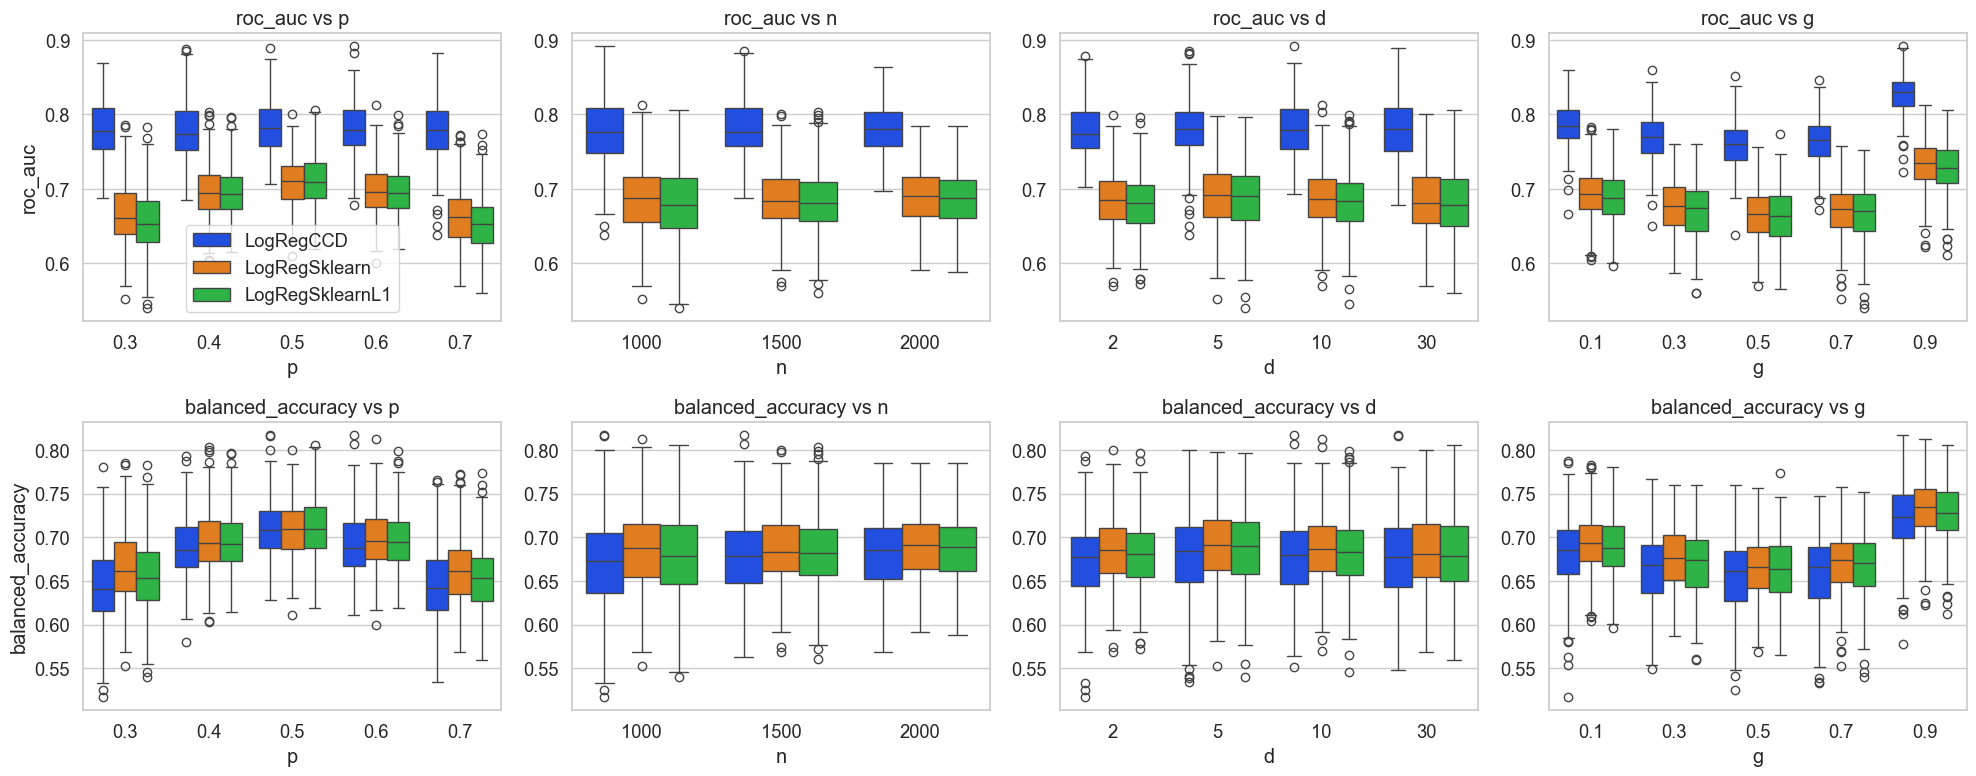

In [45]:
# Plot the results of the synthetic dataset experiment in a facet grid. Examine the effects of the parameters on the model performance
plot_synthetic_parameter_facet_grid_boxplot(results_df)

In terms of balanced accuracy the LogRegCCD models performs very similarly to the Scikit's logistic regression in all test cases. However it achieves slighly lower results on average.

In terms of ROC AUC it achieves much higher results than Scikit's logistic regression models. TODO: ?

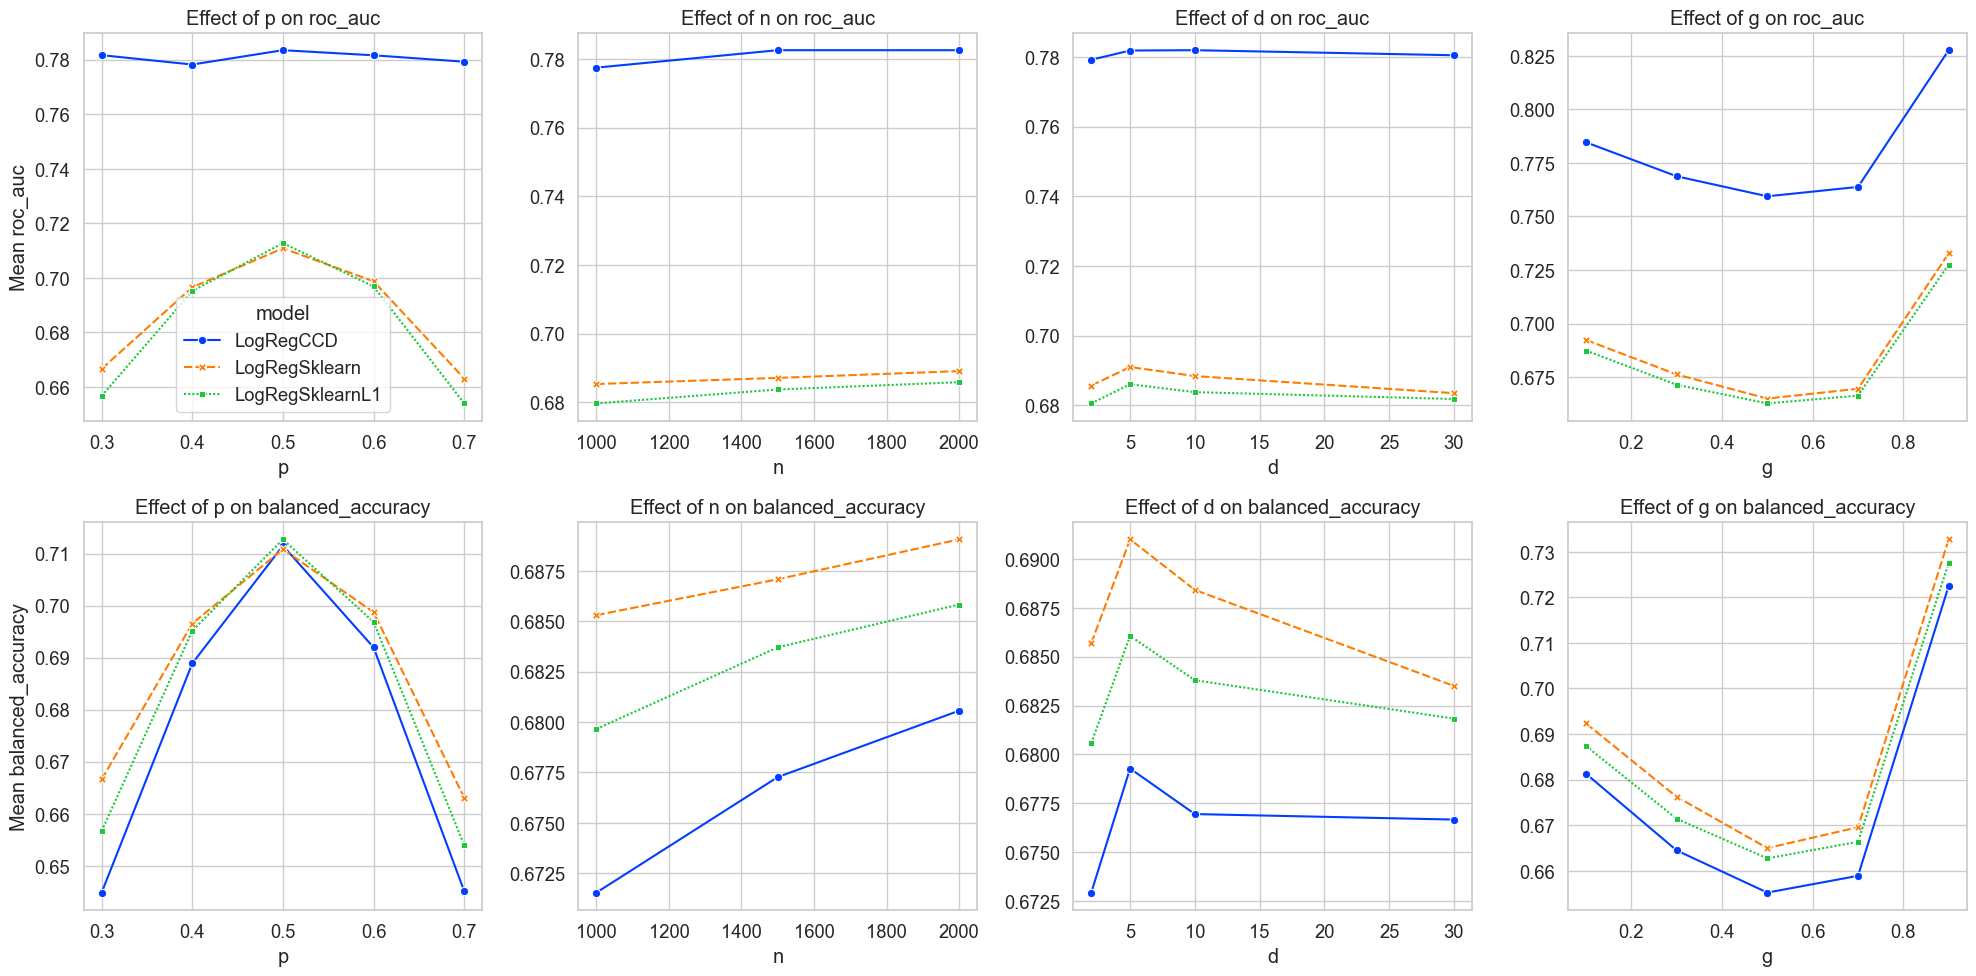

In [46]:
# Plot the results of the synthetic dataset experiment in a facet grid. Examine the effects of the parameters on the average model performance
plot_synthetic_parameter_facet_grid_mean(results_df)

The effects of the synthetic dataset features: p - class prior probability, n - number of samples, d - number of features, g - covariance of the features, on the performance of the models are as follows:
- p: As the the class prior probability diverges from 0.5 the balanced accuracy decrease. The dataset becomes more imbalanced and the model struggles to predict the minority class. TODO: ROC AUC IS IT REALLY CORRECT FOR LOGISTINC REGRESSION?
- n: As the number of samples increases the balanced accuracy increases. The model has more data to learn from and can generalize better. Similarly for ROC AUC.
- d: As the number of features increases the balanced accuracy decreases. The model has more features to learn from but some of them are not informative and can introduce noise. Similarly for ROC AUC.
- g: Here, we see a tilteld U shaped curved, as the covarianc increase the balanced accuracy decreases until around 0.7 where it starts to rapidly increase. TODO: Why?

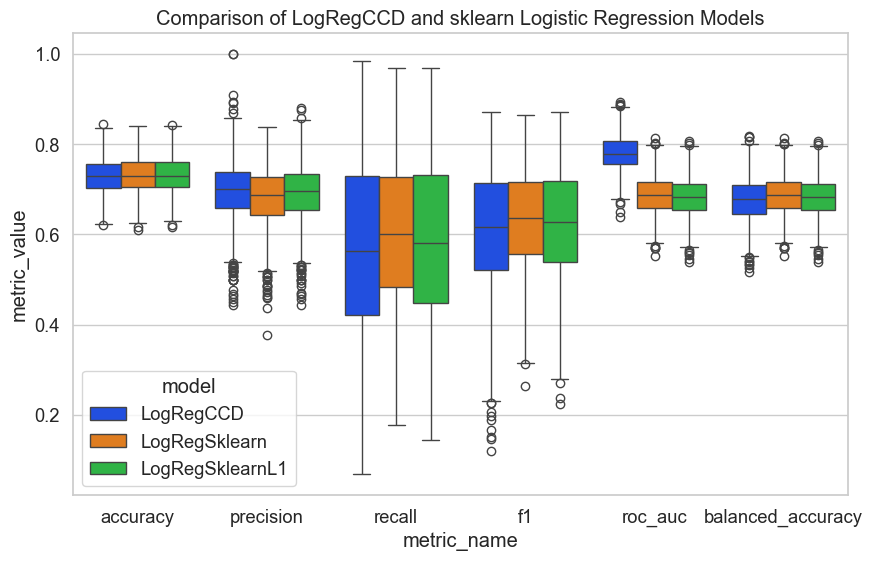

In [47]:
# Plot the overall comparison of the models on the synthetic dataset in terms of all collected metrics
plot_synthetic_overall_comparison_boxplot(results_df)

All models perform very similarly on average, except for the ROC AUC metric, where LogRegCCD outperforms other models.

## Discussion about correctness of the LogRegCCD algorithm

### Coefficient values

TODO: Add similar plots for the real datasets

### Synthetic dataset

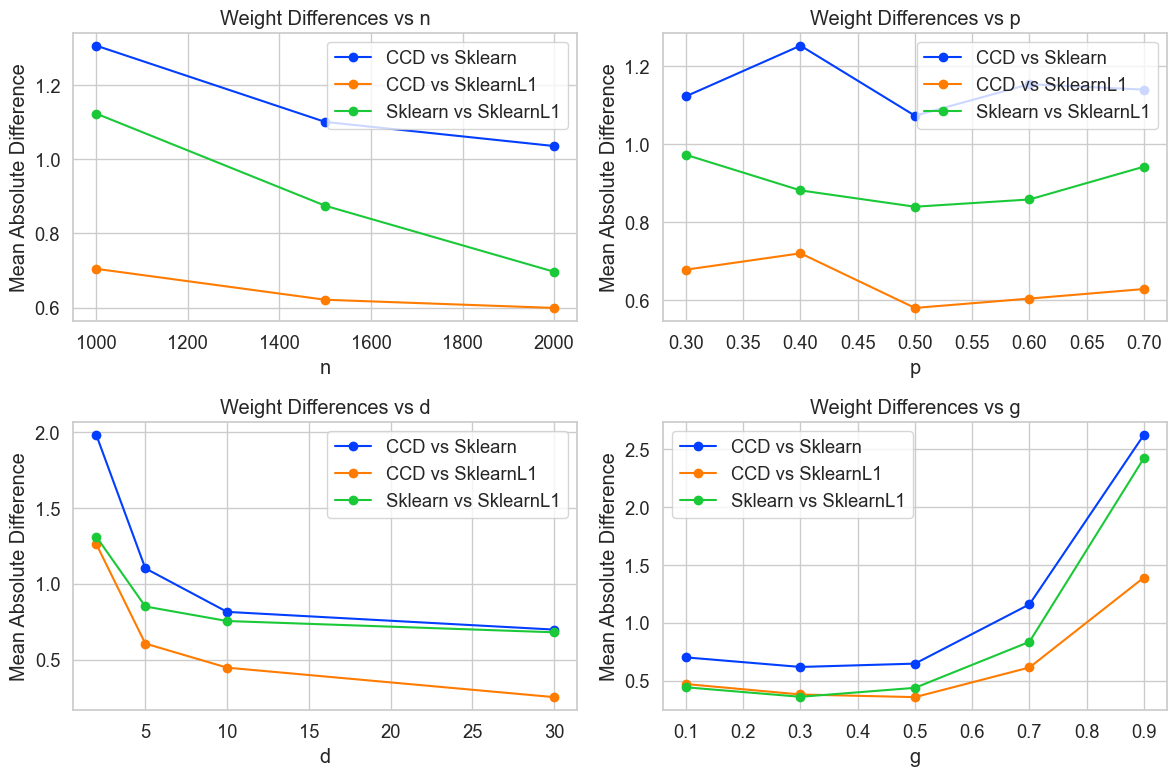

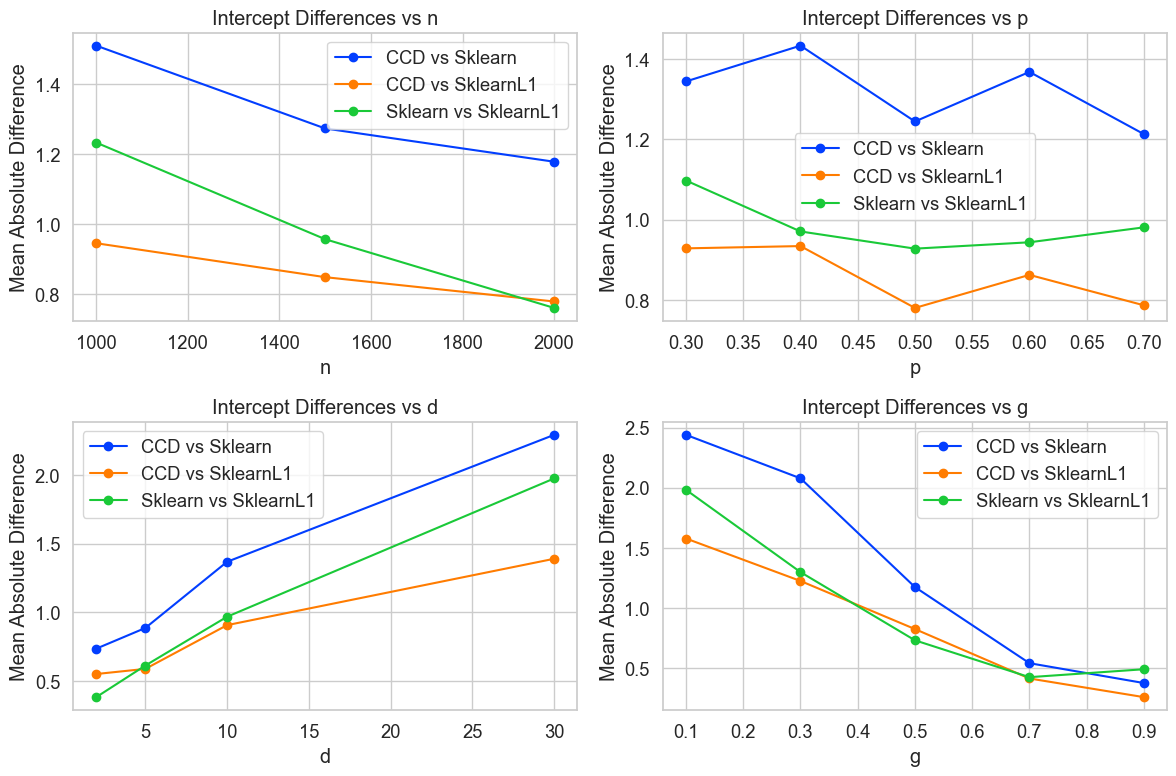

In [ ]:
# Calculate the differences in weights between the models on the synthetic dataset
differences_df = calculate_average_coefficients_differences_synthetic(results_df)

# Plot the differences in weights between the models on the synthetic dataset
plot_synthetic_coefficients_differences(differences_df)


# Plot the differences in intercepts between the models on the synthetic dataset
plot_synthetic_intercept_differences(differences_df)

The differences between coefficients between different models follow the same patterns, suggesting the similarity in the model's implementation and what follows correctness of the implemented algorithm.

### The case when p>>n

TODO: Currently it doesn't really show anything, we should either improve it or remove it

In [ ]:
p_n_parameters = {
    "p": [0.5],
    "n": [10, 30, 50],
    "d": [70, 100, 150],
    "g": [0.3, 0.1, 0.5, 0.7, 0.9],
}

p_n_test_cases = create_test_cases_all_combinations(p_n_parameters)

In [ ]:
p_n_results = []
seeds = [
    CONST_RANDOM_SEED,
]
metrics = [
    accuracy,
    precision,
    recall,
    f1,
    roc_auc,
    balanced_accuracy,
]

# Perform the experiments with the defined parameters
for i, test_case in enumerate(p_n_test_cases):
    print(f"Progress: {i}/{len(p_n_test_cases)}", end="\r")
    perform_experiment(test_case, p_n_results, seeds, metrics)

In [ ]:
p_n_results_df = pd.DataFrame(p_n_results)
p_n_results_df.to_pickle(
    f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_P_N_RESULTS_FILE_NAME}"
)
del p_n_results_df

In [ ]:
p_n_results_df = pd.read_pickle(
    f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_P_N_RESULTS_FILE_NAME}"
)

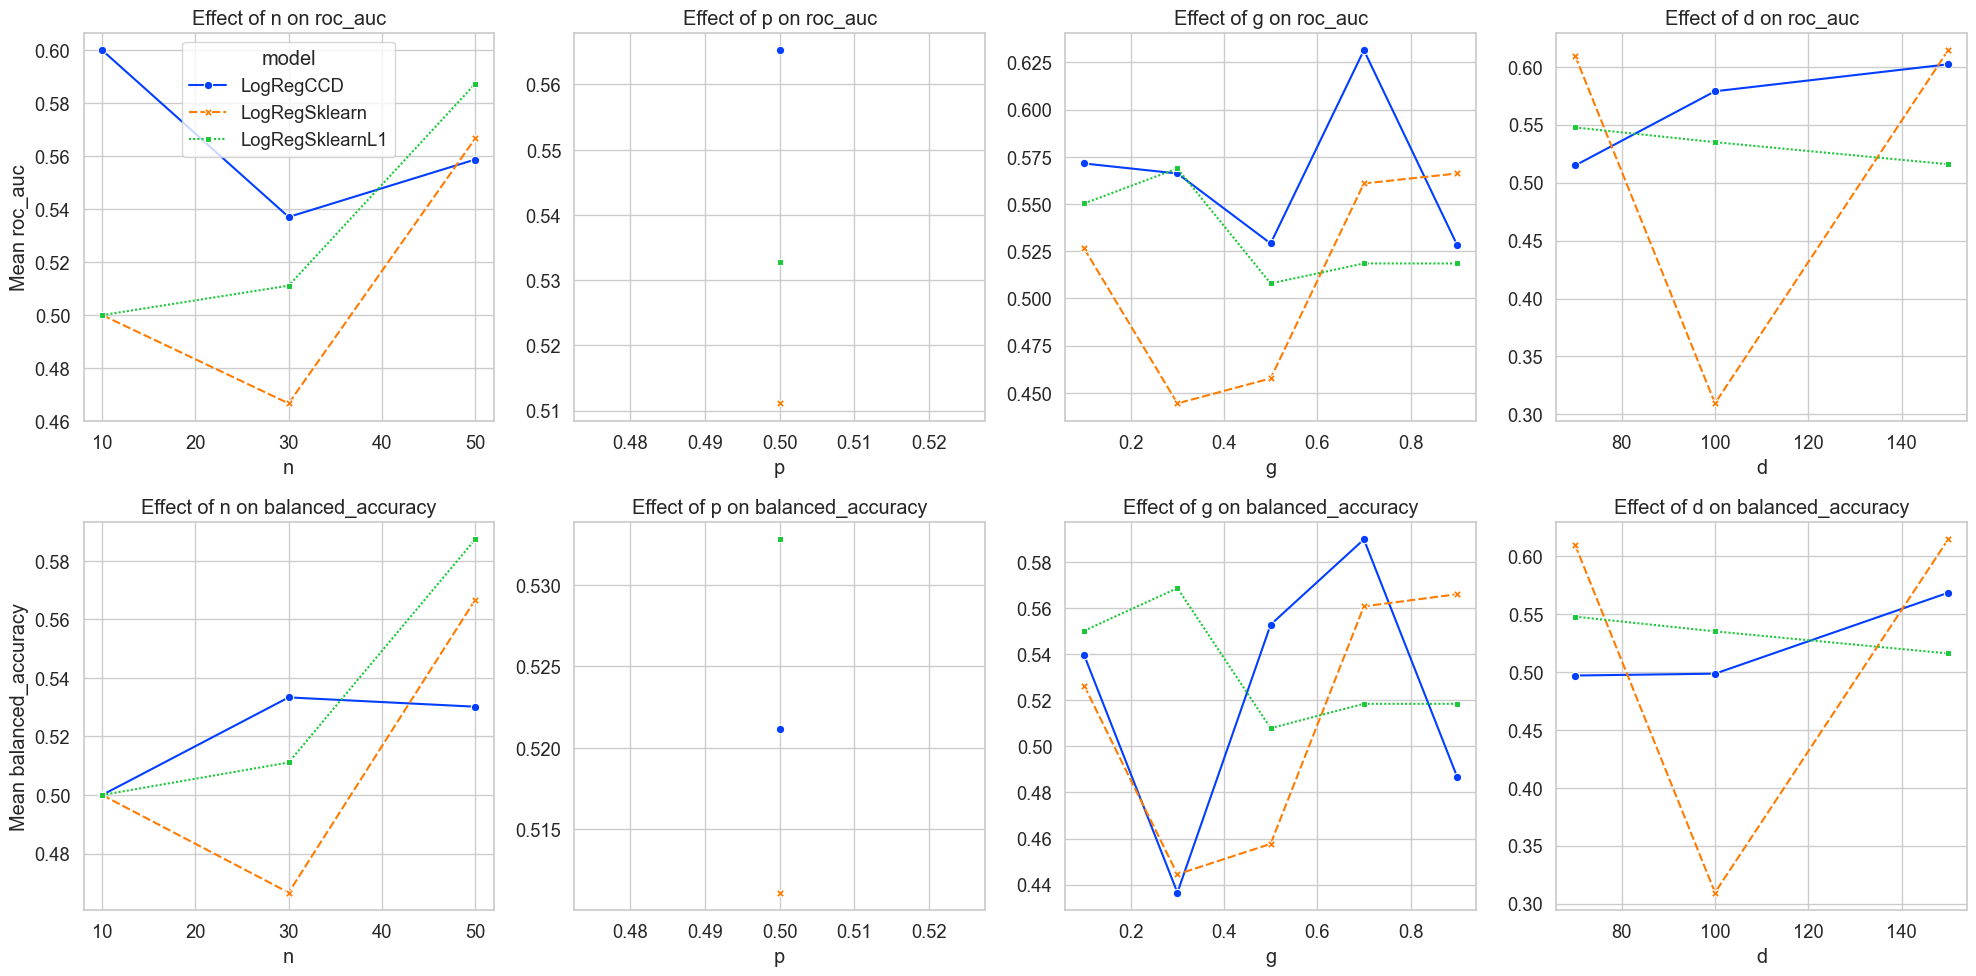

In [ ]:
plot_synthetic_parameter_facet_grid_mean(
    pd.DataFrame(p_n_results),
    parameters=["n", "p", "g", "d"],
    file_name="p_n_parameter_facet_grid",
)

### Dataset with known redundant features


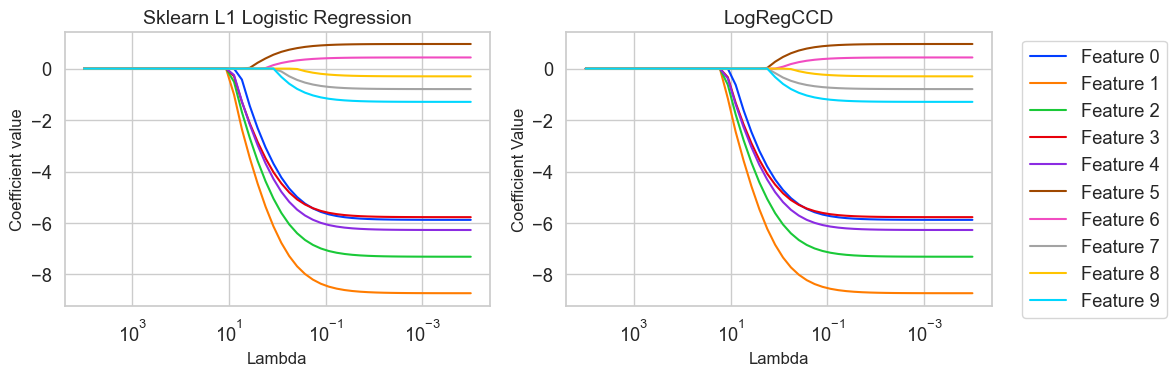

In [202]:
dataset = RedundantFeaturesDataset(
    n_features=10, n_informative=5, random_state=CONST_RANDOM_SEED
)
X_train, X_test, y_train, y_test = train_test_split(
    dataset.X, dataset.y, test_size=0.4, random_state=CONST_RANDOM_SEED
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=CONST_RANDOM_SEED
)
plot_scikit_logistic_regression_l1_logregccd_coefficients(
    X_train,
    y_train,
    figure_size=(12, 4),
    regularization_path_inverse=np.logspace(-4, 4, 50),
    random_state=CONST_RANDOM_SEED,
    file_name="logistic_regression_l1_logregccd_coefficients_redundant_features",
)

In the generated dataset there are 10 features, from which 5 are redundant. Both models correctly choose the informative features and set the redundant features close to 0.

In [203]:
logRegCCD = LogRegCCD()
logRegCCD.fit(
    X_train,
    y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    measure=accuracy_score,
    regularization_path_lambda_sequence=np.logspace(-4, 4, 50),
)

logisticRegression = LogisticRegression(
    penalty="l1", solver="liblinear", C=1 / logRegCCD.best_lambda
)

logisticRegression.fit(X_train, y_train)

redundant_comparison_results = {
    "LogRegCCD weights": logRegCCD.best_beta,
    "LogRegCCD intercept": logRegCCD.best_beta_0,
    "LogRegSklearn weights": logisticRegression.coef_[0],
    "LogRegSklearn intercept": logisticRegression.intercept_[0],
    "Chosen lambda": logRegCCD.best_lambda,
    "LogRegCCD balanced accuracy score": logRegCCD.validate(
        X_test, y_test, balanced_accuracy_score, best_lambda=True
    ),
    "LogRegSklearn balanced accuracy score": balanced_accuracy_score(
        y_test, logisticRegression.predict(X_test)
    ),
}

redundant_comparison_results_df = pd.DataFrame([redundant_comparison_results])
redundant_comparison_results_df.to_pickle(
    f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_REDUNDANT_COMPARISON_RESULTS_FILE_NAME}"
)

redundant_comparison_results

{'LogRegCCD weights': array([-5.87958924, -8.73062934, -7.31218684, -5.77412537, -6.27313637,
         0.9565    ,  0.4333742 , -0.79626411, -0.30080543, -1.29294407]),
 'LogRegCCD intercept': np.float64(18.05561699939755),
 'LogRegSklearn weights': array([-5.87768607, -8.72847793, -7.3104428 , -5.77278615, -6.27169707,
         0.9568829 ,  0.43358825, -0.79568057, -0.30040696, -1.2922838 ]),
 'LogRegSklearn intercept': np.float64(18.050089812417603),
 'Chosen lambda': np.float64(0.0001),
 'LogRegCCD balanced accuracy score': np.float64(0.7846284628462846),
 'LogRegSklearn balanced accuracy score': np.float64(0.7846284628462846)}

The resulting coefficients and intercepts of both models are nearly identical, further suggesting the correctness of the implementation.

### Comparison of coefficients' paths with Scikit's Logistic Regression with L1

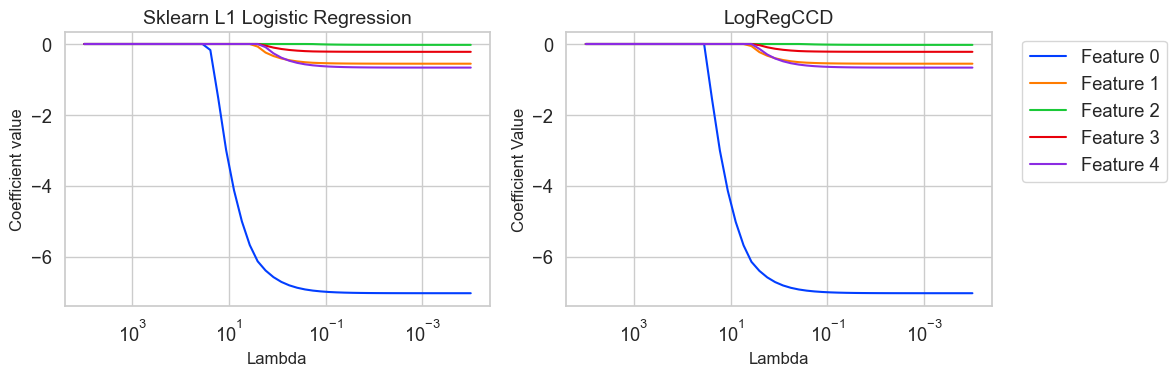

In [181]:
dataset = SyntheticDataset(p=0.5, n=1000, d=5, g=0.5)
X_train, X_test, y_train, y_test = train_test_split(
    dataset.X, dataset.y, test_size=0.2, random_state=0
)

plot_scikit_logistic_regression_l1_logregccd_coefficients(
    X_train,
    y_train,
    figure_size=(12, 4),
    regularization_path_inverse=np.logspace(-4, 4, 50),
    file_name="logistic_regression_l1_logregccd_coefficients_synthetic_dataset",
)

Both models' coefficients paths are very similar, suggesting the correctness of the implementation. The coefficients paths are not identical, but they are very close to each other. The differences in the coefficients paths are likely due to the different optimization algorithms used by both models.

### Performance of the algorithm at lambda = 0

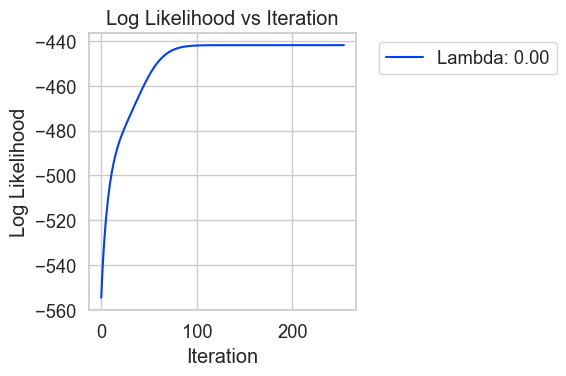

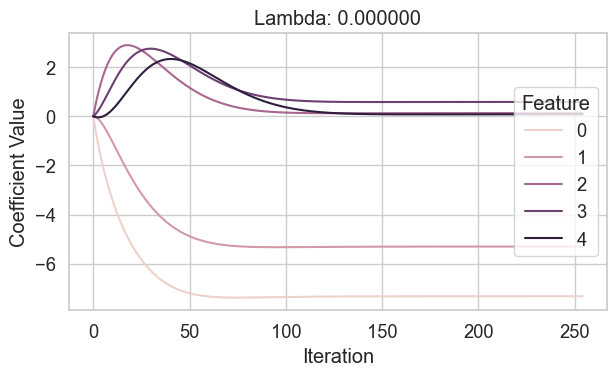

{'LogRegCCD coefficients': array([-7.32733522, -5.30386094,  0.13332994,  0.58733265,  0.08325029]),
 'LogRegCCD intercept': np.float64(5.28556810931206),
 'LogRegSklearn coefficients': array([-7.33140282, -5.31290844,  0.13153373,  0.59723648,  0.08157311]),
 'LogRegSklearn intercept': np.float64(5.287815544244289),
 'LogRegCCD balanced accuracy score': np.float64(0.7488658130859966),
 'LogRegSklearn balanced accuracy score': np.float64(0.7488658130859966)}

In [19]:
dataset = RedundantFeaturesDataset(
    n_features=5, n_informative=2, random_state=CONST_RANDOM_SEED
)
X_train, X_test, y_train, y_test = train_test_split(
    dataset.X, dataset.y, test_size=0.2, random_state=0
)
logRegCCD = LogRegCCD()
logRegCCD.fit(
    X_train,
    y_train,
    regularization_path_lambda_sequence=[0],
    track_likelihood_and_weights=True,
)

logisticRegression = LogisticRegression(penalty=None, solver="lbfgs")

logisticRegression.fit(X_train, y_train)

lambda_at_0_results = {
    "LogRegCCD coefficients": logRegCCD.beta,
    "LogRegCCD intercept": logRegCCD.beta_0,
    "LogRegSklearn coefficients": logisticRegression.coef_[0],
    "LogRegSklearn intercept": logisticRegression.intercept_[0],
    "LogRegCCD balanced accuracy score": logRegCCD.validate(
        X_test, y_test, balanced_accuracy_score, best_lambda=False
    ),
    "LogRegSklearn balanced accuracy score": balanced_accuracy_score(
        y_test, logisticRegression.predict(X_test)
    ),
}

# Implemented model correctly maximizes the log-likelihood function

logRegCCD.plot_log_likelihood(file_name="log_likelihood_synthetic_dataset_lambda_0")

logRegCCD.plot_coefficients_based_on_iteration(file_name="coefficients_synthetic_dataset_lambda_0")

# The weights of the implemented model at lambda = 0 and the weights of the sklearn model are nearly equal
# Moreover without regularization the redundant features coefficients are not being set to 0

lambda_at_0_results_df = pd.DataFrame(lambda_at_0_results)
lambda_at_0_results_df.to_pickle(
    f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_COMPARISON_AT_LAMBDA_0_RESULTS_FILE_NAME}"
)

lambda_at_0_results

At lambda = 0 the models posseses no regularization. Here we examine the behaviour of the likelihood function based on the middle loop iterations. The likelihood function is increasing with each iteration, suggesting that the model is converging to a local optimum. The coefficients are also changing with each iteration, suggesting that the model is learning from the data. The model does not perform the default 1000 iterations, meaning it successfully converged to a local optimum. 

### Likelihood function values and coefficient values depending on iteration

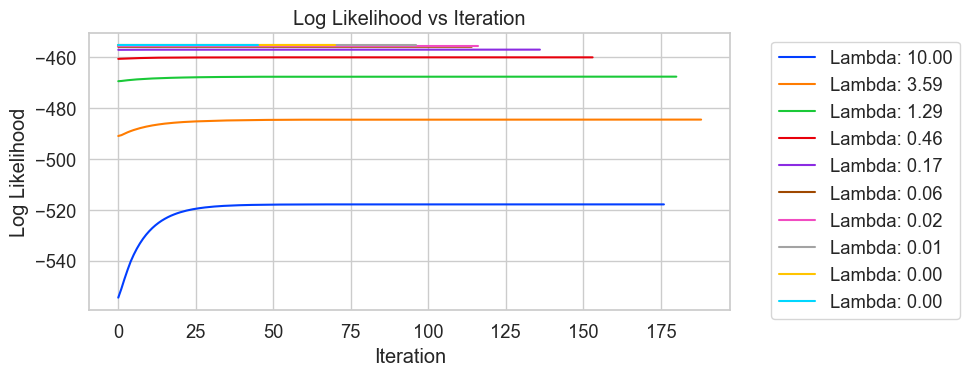

In [20]:
logRegCCD = LogRegCCD()

syntheticDataset = SyntheticDataset(p=0.5, n=1000, d=5, g=0.5)

X_train, X_test, y_train, y_test = train_test_split(
    syntheticDataset.X, syntheticDataset.y, test_size=0.2, random_state=0
)
logRegCCD.fit(
    X_train,
    y_train,
    regularization_path_lambda_sequence=np.logspace(1, -3, 10),
    track_likelihood_and_weights=True,
)
logRegCCD.plot_log_likelihood(
    figsize=(10, 4), file_name="log_likelihood_synthetic_dataset"
)

The log likelihood changes most rapidly for the largest lambda value. 

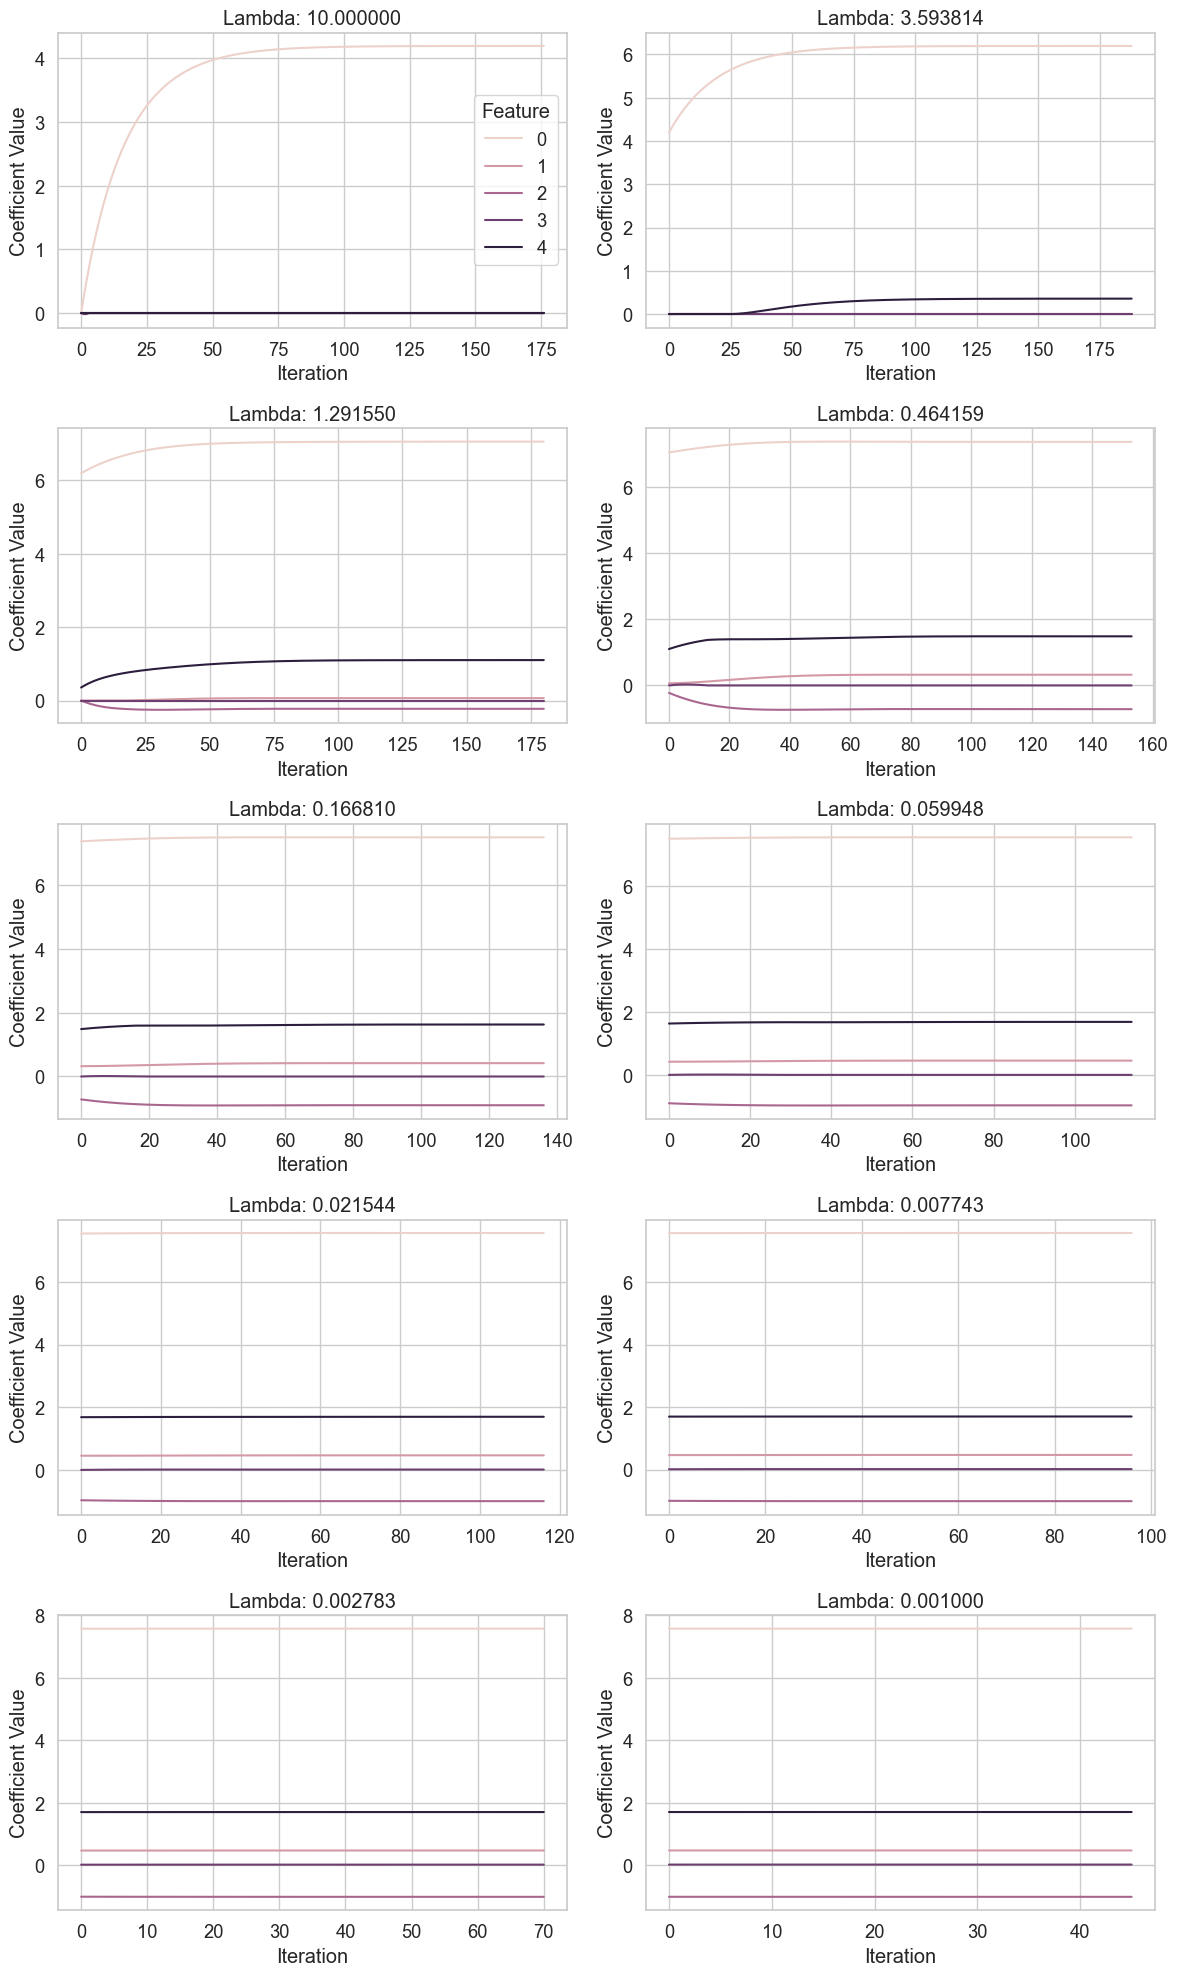

In [21]:
logRegCCD.plot_coefficients_based_on_iteration(
    figsize=(10, 4), file_name="coefficients_synthetic_dataset"
)